In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
import cv2
from common.camera import *
from common.mocap_dataset import MocapDataset
from common.xianhui_dataset import XianhuiDataset, xianhui_data_processing
from common.skeleton import Skeleton
from common.utils import *
import glob

import plotly
import plotly.graph_objs as go
import numpy as np
import json
from common.h36m_dataset import Human36mDataset
from common.visualization import *
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

In [3]:
cam_0_data_path = "../../wild_data/2019.05.30_14.03/1.json"
cam_0_img_paths = ["../../wild_data/2019.05.30_14.03/BonesInfo_Camera_1/{}.png".format(str(i+1)) for i in range(49)]
cam_0_img_cal_paths = glob.glob('../../wild_data/2019.05.30_14.03/Camera_0/*.png')
pts_3d, cam_0_pts_2d, cam_0_params, cam_0_imgs = xianhui_data_processing(cam_0_data_path, cam_0_img_paths, cam_0_img_cal_paths, cam_id = "cam_0", chess_board_shape = (7, 5))

calibrate camera
load 3d and 2d skeletons
estimate extrinsics


In [6]:
cam_1_data_path = "../../wild_data/2019.05.30_14.03/2.json"
cam_1_img_paths = ["../../wild_data/2019.05.30_14.03/BonesInfo_Camera_2/{}.png".format(str(i+1)) for i in range(49)]
cam_1_img_cal_paths = glob.glob('../../wild_data/2019.05.30_14.03/Camera_1/*.png')
pts_3d, cam_1_pts_2d, cam_1_params, cam_1_imgs = xianhui_data_processing(cam_1_data_path, cam_1_img_paths, cam_1_img_cal_paths, cam_id = "cam_1", chess_board_shape = (7, 5))

calibrate camera
load 3d and 2d skeletons
estimate extrinsics


In [7]:
cameras = {}
cameras["S1"] = [cam_0_params, cam_1_params]
data = {}
data["S1"] = {}
data["S1"]["somba"] = {
    "positions" : pts_3d,
    "cameras" : cameras["S1"]
}

dataset = XianhuiDataset(cameras, data)

In [8]:
skeleton = dataset.skeleton()

In [9]:
# def xianhui_data_processing(data_path, img_paths, img_cal_paths, cam_id, chess_board_shape = (7, 5)):
#     # camera calibration
#     intrinsics, distortion = camera_calibration(chess_board_shape, img_cal_paths)
#     print("calibrate camera")
    
#     # load simulation data
#     with open(data_path, 'r') as f:
#         data = json.loads(f.read())
    
#     imgs = np.array([plt.imread(img) for img in img_paths])
#     img_id, h, w, n_channel = imgs.shape

#     pts_3d, pts_2d = wild2human36m_xianhui(data, w, h)
#     print("load 3d and 2d skeletons")
    
#     # estimate extrinsics
#     obj_pts = pts_3d.reshape(-1,3,1)
#     img_pts = pts_2d.reshape(-1,2,1)
#     _, rvec, tvec, _ = cv2.solvePnPRansac(obj_pts, img_pts, intrinsics, distortion)
#     rmat, _ = cv2.Rodrigues(rvec)
#     extrinsics = np.zeros((3,4))
#     extrinsics[:,:3] = rmat
#     extrinsics[:,3] = tvec.reshape(-1)
#     print("estimate extrinsics")

#     camera_params = {}
#     camera_params["intrinsics"] = intrinsics
#     camera_params["extrinsics"] = extrinsics
#     camera_params["rvec"] = rvec
#     camera_params["tvec"] = tvec
#     camera_params["distortion"] = distortion
#     camera_params["res_w"] = w
#     camera_params["res_h"] = h
#     camera_params["id"] = cam_id
    
#     return pts_3d, pts_2d, camera_params, imgs

In [12]:
# xianhui_skeleton = Skeleton(parents=[-1,  0,  1,  2,  0,  4,  5,  0,  7,  8,  9,  8, 11, 12,  8, 14, 15],
#        joints_left=[4, 5, 6, 11, 12, 13],
#        joints_right=[1, 2, 3, 14, 15, 16])


# class XianhuiDataset(MocapDataset):
#     def __init__(self, cameras, data):
#         super().__init__(fps=60, skeleton=xianhui_skeleton)
#         self._cameras = cameras
#         self._data = data

In [16]:
# human36m_path = "./data/data_3d_h36m.npz"
# human36m = Human36mDataset(human36m_path)
# skeleton = human36m.skeleton()


In [33]:
def world2camera(pts_3d_world_homo, rvec, tvec):
    rmat, _ = cv2.Rodrigues(rvec)
    extrinsics = np.zeros((4,4))
    extrinsics[:3,:3] = rmat
    extrinsics[:3,3] = tvec.reshape(-1)
    extrinsics[3,3] = 1
    
    pts_3d_cam = np.matmul(extrinsics, pts_3d_world_homo)
    
    return pts_3d_cam

In [38]:
import numpy as np

In [39]:
def camera2world(pts_3d_cam_homo, rvec, tvec):
    rmat, _ = cv2.Rodrigues(rvec)
    extrinsics = np.zeros((4,4))
    extrinsics[:3,:3] = rmat
    extrinsics[:3,3] = tvec.reshape(-1)
    extrinsics[3,3] = 1
    
    pts_3d_cam = np.matmul(np.linalg.inv(extrinsics), pts_3d_cam_homo)
    
    return pts_3d_cam

In [15]:
def camera2screen(pts_3d_cam, intrinsics):
    proj_2d = np.matmul(intrinsics, pts_3d_cam)
    proj_2d_homo = proj_2d / proj_2d[-1]
    
    return proj_2d_homo[:2].T

In [34]:
# projection from 3d to 2d
obj_pts = pts_3d.reshape(-1,3,1)
proj_2d_, _ = cv2.projectPoints(obj_pts, 
                               cam_0_params["rvec"], 
                               cam_0_params["tvec"], 
                               cam_0_params["intrinsics"],
                               cam_0_params["distortion"])
proj_2d_ = proj_2d.reshape(-1,17,2)

In [40]:
pts_3d_homo.shape

(4, 4573)

In [44]:
# projection from 3d to 2d seperate, without distortion
nframe = 269
pts_3d_homo = np.ones((nframe, 17, 4))
pts_3d_homo[... , :3] = pts_3d
pts_3d_homo = pts_3d_homo.reshape(-1, 4).T

pts_3d_cam = world2camera(pts_3d_homo, cam_0_params["rvec"], cam_0_params["tvec"])
pts_3d_world = camera2world(pts_3d_cam, cam_0_params["rvec"], cam_0_params["tvec"])
proj_2d = camera2screen(pts_3d_cam[:3], cam_0_params["intrinsics"])
proj_2d = proj_2d.reshape(-1, 17, 2)

In [45]:
from common.visualization import *

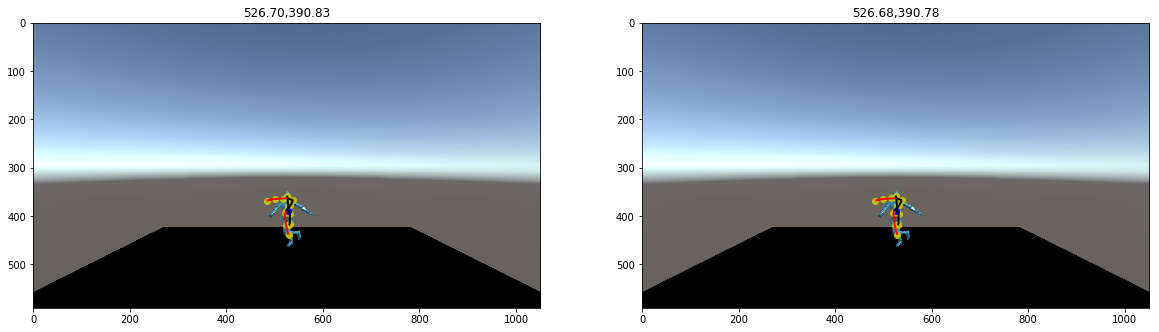

In [46]:
m = 10
gt_2d = cam_0_pts_2d[m]
fig = plt.figure(figsize=(20,20))
ax_2d_gt = fig.add_subplot(1,2,1, aspect='equal')
ax_2d_gt = display_2D_skeleton_beta(ax_2d_gt, gt_2d, skeleton, cam_0_imgs[m])
ax_2d_gt.scatter(gt_2d[0][0], gt_2d[0][1], c = "b")
ax_2d_gt.set_title("{:6.2f},{:6.2f}".format(gt_2d[0][0], gt_2d[0][1]))

pr_2d = proj_2d[m]
ax_2d_pr = fig.add_subplot(1,2,2, aspect='equal')
ax_2d_pr = display_2D_skeleton_beta(ax_2d_pr, pr_2d, skeleton, cam_0_imgs[m])
ax_2d_pr.scatter(pr_2d[0][0], pr_2d[0][1], c = "b")
ax_2d_pr.set_title("{:6.2f},{:6.2f}".format(pr_2d[0][0], pr_2d[0][1]))

plt.show()

In [ ]:
# def camera_calibration(chess_board_shape, images):
#     # termination criteria
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
#     c_columns = chess_board_shape[0]
#     c_rows = chess_board_shape[1]
    
#     # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
#     objp = np.zeros((c_rows * c_columns,3), np.float32)
#     objp[:,:2] = np.mgrid[0:c_columns, 0:c_rows].T.reshape(-1,2) * 1000
    
#     # Arrays to store object points and image points from all the images.
#     objpoints = [] # 3d point in real world space
#     imgpoints = [] # 2d points in image plane.
    
#     for fname in images:
#         img = cv2.imread(fname)
#         gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#         # Find the chess board corners
#         ret, corners = cv2.findChessboardCorners(gray, (c_columns,c_rows),None)

#         # If found, add object points, image points (after refining them)
#         if ret == True:
#             objpoints.append(objp)

#             corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
#             imgpoints.append(corners2)
            
#     ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
#     return mtx, dist

In [11]:
# xianhui_kpts_name = list(data["1"].keys())[1:]
# xianhui_kpts_dict = {}
# xianhui_kpts_inverse_dict = {}
# for i in range(len(xianhui_kpts_name)):
#     xianhui_kpts_dict[xianhui_kpts_name[i]] = i
#     xianhui_kpts_inverse_dict[i] = xianhui_kpts_name[i]

# human36m_kpts_name = ['Pelvis', 'RHip', 'RKnee', 'RAnkle','LHip','LKnee',
#                       'LAnkle','Spine1','Neck', 'Head','Site','LShoulder',
#                       'LElbow','LWrist','RShoulder', 'RElbow','RWrist']
# human36m_kpts_dict = {}
# human36m_kpts_inverse_dict = {}
# for i in range(17):
#     human36m_kpts_dict[human36m_kpts_name[i]] = i
#     human36m_kpts_inverse_dict[i] = human36m_kpts_name[i]
    
# pair = [(0,5),(1,18),(2,19),(3,20),(4,10),(5,11),(6,12),(7,3),(8,1),(9,0),(10,0),(11,7),(12,8),(13,9),(14,15),(15,16),(16,17)]

# pts_3d = []
# pts_2d = []

# for i in range(len(data)-1):
#     pts_3d_ = []
#     pts_2d_ = []

#     for p in pair:
#         x = data[str(i+1)][xianhui_kpts_inverse_dict[p[1]]]["x"]
#         y = data[str(i+1)][xianhui_kpts_inverse_dict[p[1]]]["y"]
#         z = data[str(i+1)][xianhui_kpts_inverse_dict[p[1]]]["z"]
#         x_2d = data[str(i+1)][xianhui_kpts_inverse_dict[p[1]]]["view_x"]
#         y_2d = data[str(i+1)][xianhui_kpts_inverse_dict[p[1]]]["view_y"]
#         pts_3d_.append([x,y,z])
#         # pts_2d_.append([(x_2d), (y_2d)])
#         pts_2d_.append([(x_2d)*w, (1-y_2d)*h])
        
#     pts_3d.append(pts_3d_)
#     pts_2d.append(pts_2d_)
    
    
# pts_3d = np.array(pts_3d)
# pts_2d = np.array(pts_2d)